# F-MNIST compare

I intend to compare the results from the original paper with the ones I obtained on the dataset Fashion-MNIST.

Let's first check that I have all the runs. 

In [1]:
# setup

# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path

In [2]:
%cd ~/fcdd/data/results
%ls | grep fmnist

/data/bertoldo/fcdd-data/results
fcdd_20211220193242_fmnist_/
fcdd_20211220193242_fmnist__AE/
fcdd_20211220193242_fmnist__AE.bkp/
fcdd_20211220193242_fmnist_.bkp/
fcdd_20211220193242_fmnist__HSC/
fcdd_20211220193450_fmnist_/
fcdd_20211220193450_fmnist__AE/
fcdd_20211220193450_fmnist__HSC/
fcdd_20211224164558consistency_fold0_fmnist_/
fcdd_20211224164631consistency_fold1_fmnist_/
fcdd_20211224164652consistency_fold2_fmnist_/
fcdd_20220117120505consistency_fold0_pt2_fmnist_/
fcdd_20220117121130consistency_fold1_pt2_fmnist_/
fcdd_20220117154522consistency_fold1_pt3_fmnist_/
fcdd_20220117154747consistency_fold2_pt2_fmnist_/
fcdd_20220119140701consistency_fold2_pt3_fmnist_/
fmnist/


Because the experiments were cut due to issues in the machine, they are split in several folders, so I "merged" them by creating symbolic links.

In [3]:
%cd ~/fcdd/data/results/fmnist/
%ls

/data/bertoldo/fcdd-data/results/fmnist
OE-CIFAR100/  OE-CIFAR100-consistency/  OE-EMNIST/


# F-MNIST (OE-EMNIST)

This is the setting where the Outlier Exposure (OE) is done with EMNIST.

In [4]:
%cd ~/fcdd/data/results/fmnist/OE-EMNIST/
%ls
%cd ~/fcdd/data/results/fmnist/OE-EMNIST/fcdd_20211220193242_fmnist_
%ls 

/data/bertoldo/fcdd-data/results/fmnist/OE-EMNIST
fcdd_20211220193242_fmnist_@     fcdd_20211220193242_fmnist__HSC@
fcdd_20211220193242_fmnist__AE@
/data/bertoldo/fcdd-data/results/fcdd_20211220193242_fmnist_
all_classwise_roc_curves/  normal_2/  normal_5/  normal_8/
normal_0/                  normal_3/  normal_6/  normal_9/
normal_1/                  normal_4/  normal_7/  roc.pdf


I will plot this as a reference but the roc curves are to be rebuilt.

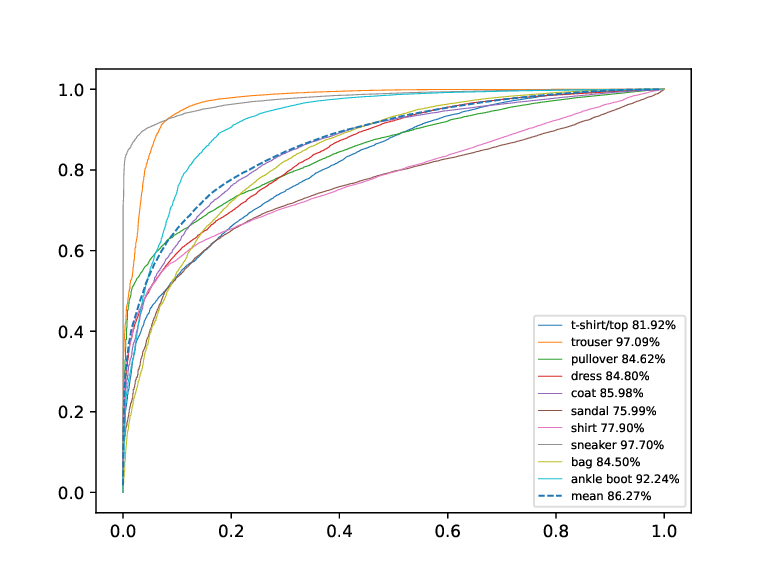

In [5]:
from wand.image import Image as WImage
pdf_path = Path.home() / '/data/bertoldo/fcdd-data/results/fcdd_20211220193242_fmnist_/roc.pdf'
pdf_rocs = WImage(filename=pdf_path, resolution=120)
pdf_rocs

## dev

In [6]:
!realpath normal_0/it_0/roc.json

/data/bertoldo/fcdd-data/results/fcdd_20211220193242_fmnist_/normal_0/it_0/roc.json


In [7]:
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json


ROC_JSON_EXPECTED_KEYS = {"tpr", "fpr", "ths", "auc"}
ROC_JSON_LISTS = {"tpr", "fpr", "ths"}


def get_roc(path: Path) -> Dict[str, Union[float, ndarray]]:
    """
    :param path: points to the 'roc.json' file inside an experiment (dataset + class + iteration)
    """
    
    with path.open("r") as json_file:
        payload = json.load(json_file)
    
    assert type(payload) == dict, f"{type(payload)=}"
    assert set(payload.keys()) == ROC_JSON_EXPECTED_KEYS, f"{set(payload.keys())=}"
    
    # transform the lists in ndarrays
    for list_key in ROC_JSON_LISTS:
        list_obj = payload[list_key]
        assert type(list_obj) == list, f"{type(list_obj)=}"
        payload[list_key] = np.array(list_obj)
        
    return payload


TEST_ROC_JSON_PATH = Path("/data/bertoldo/fcdd-data/results/fcdd_20211220193242_fmnist_/normal_0/it_0/roc.json")
test_roc = get_roc(TEST_ROC_JSON_PATH)

f'{test_roc["auc"]=}'
f'{test_roc["tpr"][:3]=}'

del TEST_ROC_JSON_PATH, test_roc

'test_roc["auc"]=0.8256965555555555'

'test_roc["tpr"][:3]=array([0.        , 0.00011111, 0.03633333])'

In [8]:
# this is to get the strings associated to the classes in the fcdd code
# copied from: fcdd/python/fcdd/datasets/__init__.py
# inside function `str_labels`
# commit: 9f268d8fd2fee33a5c5f38cdfb781da927bdb614
CLASS_LABELS = {
    'cifar10': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    'fmnist': [
        't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ],
    'mvtec': [
        'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
        'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor',
        'wood', 'zipper'
    ],
    # 'imagenet': deepcopy(ADImageNet.ad_classes),
    # this one forwards to: fcdd/python/fcdd/datasets/imagenet.py
    # in: ADImageNet.ad_classes
    # at the same commit as above
    'imagenet': ['acorn', 'airliner', 'ambulance', 'American alligator', 'banjo', 'barn', 'bikini', 'digital clock',
                  'dragonfly', 'dumbbell', 'forklift', 'goblet', 'grand piano', 'hotdog', 'hourglass', 'manhole cover',
                  'mosque', 'nail', 'parking meter', 'pillow', 'revolver', 'dial telephone', 'schooner',
                  'snowmobile', 'soccer ball', 'stingray', 'strawberry', 'tank', 'toaster', 'volcano'],
    'pascalvoc': ['horse'],
}


def get_class_label(class_dirname: str, dataset: str) -> str:
    return CLASS_LABELS[dataset][int(class_dirname.lstrip("normal_"))]


def get_all_rocs_experiment(path: Path, dataset: str) -> Dict[str, Union[str, float, ndarray]]:
    
    """
    :param path: a folder that looks like 'fcdd_20211220193242_fmnist_' 
                 a whole experiment on a dataset with all iterations and nominal classes inside, 
                 the structure should look like
                 
                path/
                path/normal_0
                path/normal_1
                ...
                path/normal_9/
                path/normal_9/it_0
                ...
                path/normal_9/it_4/roc.json
    """
    assert path.is_dir()
    assert dataset in CLASS_LABELS
    experiments = {
        (key := f"{dirpath.name}.{iterpath.name}"): {
            "key": key,
            "normal_class": dirpath.name,
            "it": iterpath.name,
            "dir": iterpath,
            "roc_json_path": (roc_json_path := iterpath / "roc.json"),
            "normal_class_label": get_class_label(dirpath.name, dataset),
            **get_roc(roc_json_path),
        }
        # first level: classes
        for dirpath in path.glob("normal_*")
        if dirpath.is_dir()
        # second level: iterations
        for iterpath in dirpath.glob("it_*")
        if iterpath.is_dir()
    }
    return experiments
    
    
TEST_EXPERIMENT_PATH = Path("/data/bertoldo/fcdd-data/results/fcdd_20211220193242_fmnist_")
test_experiment = get_all_rocs_experiment(TEST_EXPERIMENT_PATH, "fmnist")
test_experiment[list(test_experiment.keys())[0]]

del TEST_EXPERIMENT_PATH, test_experiment

{'key': 'normal_8.it_4',
 'normal_class': 'normal_8',
 'it': 'it_4',
 'dir': PosixPath('/data/bertoldo/fcdd-data/results/fcdd_20211220193242_fmnist_/normal_8/it_4'),
 'roc_json_path': PosixPath('/data/bertoldo/fcdd-data/results/fcdd_20211220193242_fmnist_/normal_8/it_4/roc.json'),
 'normal_class_label': 'bag',
 'tpr': array([0.00000000e+00, 1.11111111e-04, 1.25555556e-02, ...,
        9.99888889e-01, 1.00000000e+00, 1.00000000e+00]),
 'fpr': array([0.   , 0.   , 0.   , ..., 0.972, 0.972, 1.   ]),
 'ths': array([5.04730558e+00, 4.04730558e+00, 1.52359760e+00, ...,
        4.93763154e-03, 4.93303128e-03, 2.80969008e-03]),
 'auc': 0.8434591111111112}

## gather data

In [9]:
import pandas as pd

### load dataframe

In [10]:
experiment_path = Path("/data/bertoldo/fcdd-data/results/fcdd_20211220193242_fmnist_")
dataset = "fmnist"

records = get_all_rocs_experiment(experiment_path, dataset)

df = pd.DataFrame.from_records(data=records).T
df.head(1)

df = df.drop(columns=["dir", "roc_json_path"])
df.head(2)


,key,normal_class,it,dir,roc_json_path,normal_class_label,tpr,fpr,ths,auc
normal_0.it_0,normal_0.it_0,normal_0,it_0,/data/bertoldo/fcdd-data/results/fcdd_20211220...,/data/bertoldo/fcdd-data/results/fcdd_20211220...,t-shirt/top,"[0.0, 0.00011111111111111112, 0.03633333333333...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[3.944425344467163, 2.944425344467163, 1.69049...",0.825697


,key,normal_class,it,normal_class_label,tpr,fpr,ths,auc
normal_0.it_0,normal_0.it_0,normal_0,it_0,t-shirt/top,"[0.0, 0.00011111111111111112, 0.03633333333333...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[3.944425344467163, 2.944425344467163, 1.69049...",0.825697
normal_0.it_1,normal_0.it_1,normal_0,it_1,t-shirt/top,"[0.0, 0.00011111111111111112, 0.04288888888888...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[3.743008613586426, 2.743008613586426, 1.48422...",0.810792


### basic checks

- number of classes
- number of iterations


In [11]:
df.describe()[["key", "normal_class", "it"]]

,key,normal_class,it
count,50,50,50
unique,50,10,5
top,normal_0.it_0,normal_0,it_0
freq,1,5,10


In [12]:
df.groupby("normal_class")[["it"]].describe().T

normal_class normal_0 normal_1 normal_2 normal_3 normal_4 normal_5 normal_6  \
it count            5        5        5        5        5        5        5   
   unique           5        5        5        5        5        5        5   
   top           it_0     it_0     it_0     it_0     it_0     it_0     it_0   
   freq             1        1        1        1        1        1        1   

normal_class normal_7 normal_8 normal_9  
it count            5        5        5  
   unique           5        5        5  
   top           it_0     it_0     it_0  
   freq             1        1        1

### roc-auc

In [13]:
dataset = "fmnist"
labels_order = CLASS_LABELS[dataset]

rocauc_per_class = df.groupby("normal_class_label").agg({
    "auc": ["mean"],
})
rocauc_per_class.columns = [col_levels[0] for col_levels in rocauc_per_class.columns.to_flat_index()]

# in percentage
rocauc_per_class = 100 * rocauc_per_class
rocauc_per_class["auc"] = rocauc_per_class["auc"].round(decimals=2)
rocauc_per_class = rocauc_per_class.loc[labels_order]
rocauc_per_class.loc["mean"] = rocauc_per_class.mean(axis=0)


In [14]:
fmnist_oe_emnist_rocauc_per_class = rocauc_per_class
fmnist_oe_emnist_rocauc_per_class

,auc
normal_class_label,
t-shirt/top,81.920
trouser,97.090
pullover,84.620
dress,84.800
coat,85.980
sandal,75.990
shirt,77.900
sneaker,97.700
bag,84.500


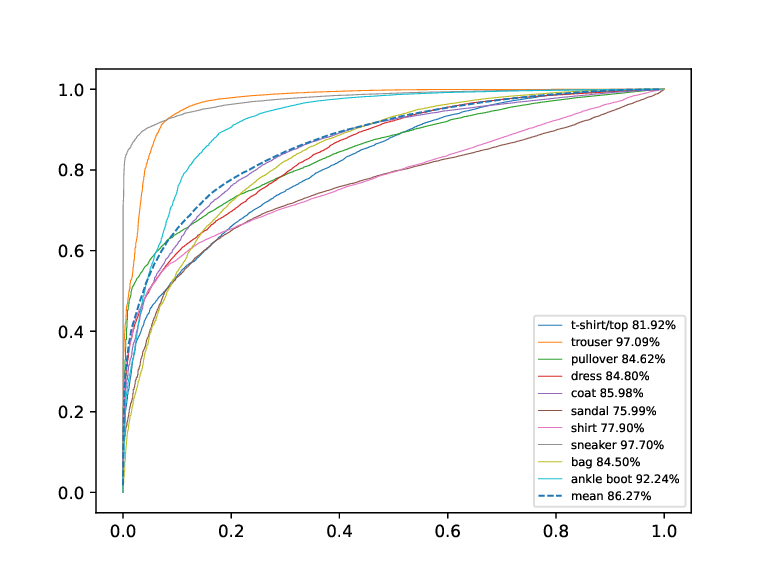

In [15]:
pdf_rocs

# F-MNIST (OE-CIFAR-100)

This is the setting where the Outlier Exposure (OE) is done with CIFAR-100.

In [16]:
%cd ~/fcdd/data/results/fmnist/OE-CIFAR100/
%ls
%cd ~/fcdd/data/results/fmnist/OE-CIFAR100/fcdd_20211220193450_fmnist_
%ls 

/data/bertoldo/fcdd-data/results/fmnist/OE-CIFAR100
fcdd_20211220193450_fmnist_@     fcdd_20211220193450_fmnist__HSC@
fcdd_20211220193450_fmnist__AE@
/data/bertoldo/fcdd-data/results/fcdd_20211220193450_fmnist_
all_classwise_roc_curves/  normal_2/  normal_5/  normal_8/
normal_0/                  normal_3/  normal_6/  normal_9/
normal_1/                  normal_4/  normal_7/  roc.pdf


I will plot this as a reference but the roc curves are to be rebuilt.

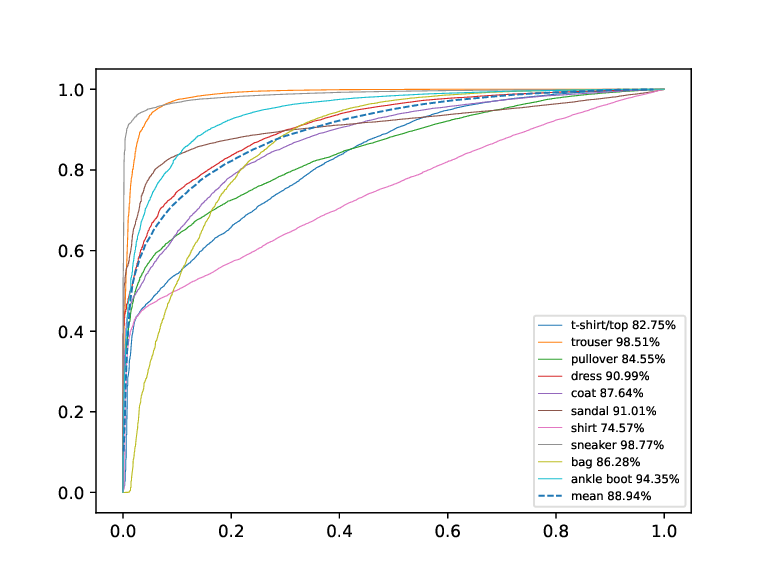

In [17]:
from wand.image import Image as WImage
pdf_path = Path.home() / 'fcdd/data/results/fmnist/OE-CIFAR100/fcdd_20211220193450_fmnist_/roc.pdf'
pdf_rocs = WImage(filename=pdf_path, resolution=120)
pdf_rocs

In [18]:
!realpath .

/data/bertoldo/fcdd-data/results/fcdd_20211220193450_fmnist_


##  gather data

In [19]:
import pandas as pd

### load dataframe

In [20]:
experiment_path = Path("/data/bertoldo/fcdd-data/results/fcdd_20211220193450_fmnist_")
dataset = "fmnist"

records = get_all_rocs_experiment(experiment_path, dataset)

df = pd.DataFrame.from_records(data=records).T
df.head(1)

df = df.drop(columns=["dir", "roc_json_path"])
df.head(2)


,key,normal_class,it,dir,roc_json_path,normal_class_label,tpr,fpr,ths,auc
normal_0.it_0,normal_0.it_0,normal_0,it_0,/data/bertoldo/fcdd-data/results/fcdd_20211220...,/data/bertoldo/fcdd-data/results/fcdd_20211220...,t-shirt/top,"[0.0, 0.00011111111111111112, 0.00966666666666...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[7.4163289070129395, 6.4163289070129395, 1.259...",0.815306


,key,normal_class,it,normal_class_label,tpr,fpr,ths,auc
normal_0.it_0,normal_0.it_0,normal_0,it_0,t-shirt/top,"[0.0, 0.00011111111111111112, 0.00966666666666...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[7.4163289070129395, 6.4163289070129395, 1.259...",0.815306
normal_0.it_1,normal_0.it_1,normal_0,it_1,t-shirt/top,"[0.0, 0.00011111111111111112, 0.00633333333333...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[8.52375841140747, 7.523758411407471, 1.720681...",0.828198


### basic checks

- number of classes
- number of iterations


In [21]:
df.describe()[["key", "normal_class", "it"]]

,key,normal_class,it
count,50,50,50
unique,50,10,5
top,normal_0.it_0,normal_0,it_0
freq,1,5,10


In [22]:
df.groupby("normal_class")[["it"]].describe().T

normal_class normal_0 normal_1 normal_2 normal_3 normal_4 normal_5 normal_6  \
it count            5        5        5        5        5        5        5   
   unique           5        5        5        5        5        5        5   
   top           it_0     it_0     it_0     it_0     it_0     it_0     it_0   
   freq             1        1        1        1        1        1        1   

normal_class normal_7 normal_8 normal_9  
it count            5        5        5  
   unique           5        5        5  
   top           it_0     it_0     it_0  
   freq             1        1        1

### roc-auc

In [23]:
dataset = "fmnist"
labels_order = CLASS_LABELS[dataset]

rocauc_per_class = df.groupby("normal_class_label").agg({
    "auc": ["mean"],
})
rocauc_per_class.columns = [col_levels[0] for col_levels in rocauc_per_class.columns.to_flat_index()]

# in percentage
rocauc_per_class = 100 * rocauc_per_class
rocauc_per_class["auc"] = rocauc_per_class["auc"].round(decimals=2)
rocauc_per_class = rocauc_per_class.loc[labels_order]
rocauc_per_class.loc["mean"] = rocauc_per_class.mean(axis=0)


In [24]:
fmnist_oe_cifar100_rocauc_per_class = rocauc_per_class
fmnist_oe_cifar100_rocauc_per_class

,auc
normal_class_label,
t-shirt/top,82.750
trouser,98.510
pullover,84.550
dress,90.990
coat,87.640
sandal,91.010
shirt,74.570
sneaker,98.770
bag,86.280


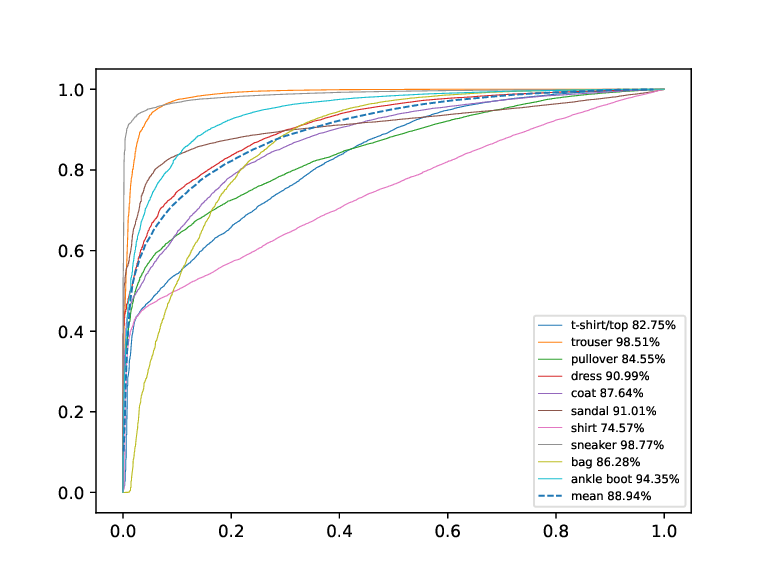

In [25]:
pdf_rocs

# F-MNIST (baseline AE)

This is the baseline on f-mnist using AE

In [26]:
%cd ~/fcdd/data/results/fmnist/OE-CIFAR100/
%ls
%cd ~/fcdd/data/results/fmnist/OE-CIFAR100/fcdd_20211220193450_fmnist__AE
%ls 

/data/bertoldo/fcdd-data/results/fmnist/OE-CIFAR100
fcdd_20211220193450_fmnist_@     fcdd_20211220193450_fmnist__HSC@
fcdd_20211220193450_fmnist__AE@
/data/bertoldo/fcdd-data/results/fcdd_20211220193450_fmnist__AE
all_classwise_roc_curves/  normal_2/  normal_5/  normal_8/
normal_0/                  normal_3/  normal_6/  normal_9/
normal_1/                  normal_4/  normal_7/  roc.pdf


I will plot this as a reference but the roc curves are to be rebuilt.

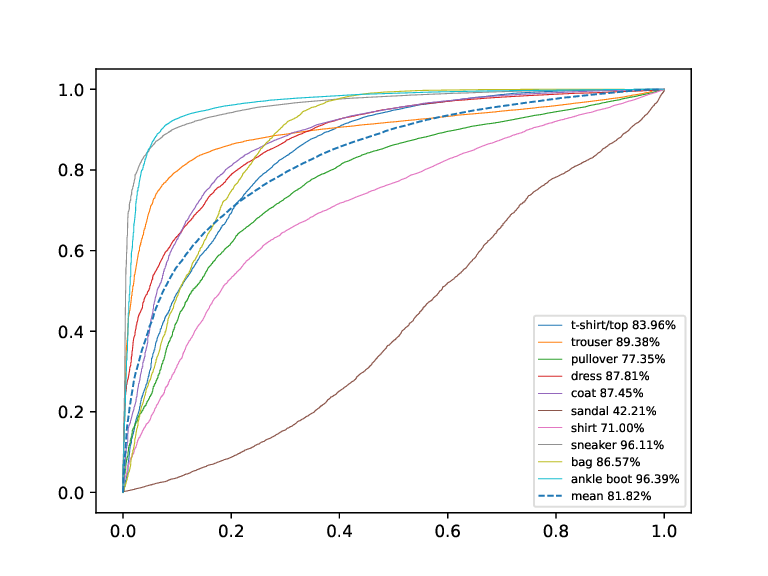

In [27]:
from wand.image import Image as WImage
pdf_path = Path.home() / '/data/bertoldo/fcdd-data/results/fcdd_20211220193450_fmnist__AE/roc.pdf'
pdf_rocs = WImage(filename=pdf_path, resolution=120)
pdf_rocs

##  gather data

In [28]:
import pandas as pd

### load dataframe

In [29]:
experiment_path = Path("/data/bertoldo/fcdd-data/results/fcdd_20211220193450_fmnist__AE")
dataset = "fmnist"

records = get_all_rocs_experiment(experiment_path, dataset)

df = pd.DataFrame.from_records(data=records).T
df.head(1)

df = df.drop(columns=["dir", "roc_json_path"])
df.head(2)


,key,normal_class,it,dir,roc_json_path,normal_class_label,tpr,fpr,ths,auc
normal_0.it_0,normal_0.it_0,normal_0,it_0,/data/bertoldo/fcdd-data/results/fcdd_20211220...,/data/bertoldo/fcdd-data/results/fcdd_20211220...,t-shirt/top,"[0.0, 0.0, 0.0008888888888888889, 0.0008888888...","[0.0, 0.001, 0.001, 0.002, 0.002, 0.003, 0.003...","[1.0076216417364776, 0.0076216417364776134, 0....",0.84185


,key,normal_class,it,normal_class_label,tpr,fpr,ths,auc
normal_0.it_0,normal_0.it_0,normal_0,it_0,t-shirt/top,"[0.0, 0.0, 0.0008888888888888889, 0.0008888888...","[0.0, 0.001, 0.001, 0.002, 0.002, 0.003, 0.003...","[1.0076216417364776, 0.0076216417364776134, 0....",0.84185
normal_0.it_1,normal_0.it_1,normal_0,it_1,t-shirt/top,"[0.0, 0.00011111111111111112, 0.00033333333333...","[0.0, 0.0, 0.0, 0.001, 0.001, 0.002, 0.002, 0....","[1.0144044486805797, 0.014404448680579662, 0.0...",0.835773


### basic checks

- number of classes
- number of iterations


In [30]:
df.describe()[["key", "normal_class", "it"]]

,key,normal_class,it
count,50,50,50
unique,50,10,5
top,normal_0.it_0,normal_0,it_0
freq,1,5,10


In [31]:
df.groupby("normal_class")[["it"]].describe().T

normal_class normal_0 normal_1 normal_2 normal_3 normal_4 normal_5 normal_6  \
it count            5        5        5        5        5        5        5   
   unique           5        5        5        5        5        5        5   
   top           it_0     it_0     it_0     it_0     it_0     it_0     it_0   
   freq             1        1        1        1        1        1        1   

normal_class normal_7 normal_8 normal_9  
it count            5        5        5  
   unique           5        5        5  
   top           it_0     it_0     it_0  
   freq             1        1        1

### roc-auc

In [32]:
dataset = "fmnist"
labels_order = CLASS_LABELS[dataset]

rocauc_per_class = df.groupby("normal_class_label").agg({
    "auc": ["mean"],
})
rocauc_per_class.columns = [col_levels[0] for col_levels in rocauc_per_class.columns.to_flat_index()]

# in percentage
rocauc_per_class = 100 * rocauc_per_class
rocauc_per_class["auc"] = rocauc_per_class["auc"].round(decimals=2)
rocauc_per_class = rocauc_per_class.loc[labels_order]
rocauc_per_class.loc["mean"] = rocauc_per_class.mean(axis=0)


In [33]:
fmnist_ae_rocauc_per_class = rocauc_per_class
fmnist_ae_rocauc_per_class

,auc
normal_class_label,
t-shirt/top,83.960
trouser,89.380
pullover,77.350
dress,87.810
coat,87.450
sandal,42.210
shirt,71.000
sneaker,96.110
bag,86.570


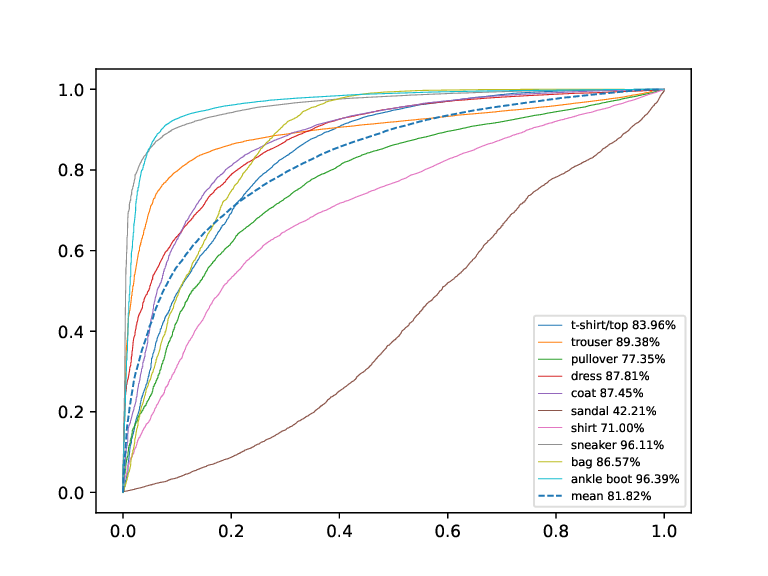

In [34]:
pdf_rocs

# compare

the paper says that using cifar-100 as oe give 3% points extra in avg relative to emnist


In [51]:
fmnist_oe_emnist_rocauc_per_class

,auc
normal_class_label,
t-shirt/top,81.920
trouser,97.090
pullover,84.620
dress,84.800
coat,85.980
sandal,75.990
shirt,77.900
sneaker,97.700
bag,84.500


In [50]:
oe_diff = fmnist_oe_cifar100_rocauc_per_class - fmnist_oe_emnist_rocauc_per_class
oe_diff

,auc
normal_class_label,
t-shirt/top,0.830
trouser,1.420
pullover,-0.070
dress,6.190
coat,1.660
sandal,15.020
shirt,-3.330
sneaker,1.070
bag,1.780


## paper data

from Table 6, page 17

this corresponds to `fmnist_ae_rocauc_per_class` and `fmnist_oe_cifar100_rocauc_per_class`

the first value at each class is `fmnist_ae_rocauc_per_class` and the fourth is `fmnist_oe_cifar100_rocauc_per_class` 

In [70]:
str_data = """
T-Shirt/Top
 0.85
 0.98
 0.99
 0.82
Trouser
 0.91
 0.90
 0.98
 0.98
Pullover
 0.78
 0.91
 0.91
 0.84
Dress
 0.88
 0.94
 0.90
 0.92
Coat
 0.88
 0.89
 0.92
 0.87
Sandal
 0.45
 0.92
 0.93
 0.90
Shirt
 0.70
 0.83
 0.83
 0.75
Sneaker
 0.96
 0.99
 0.99
 0.99
Bag
 0.87
 0.92
 0.91
 0.86
Ankle Boot
 0.96
 0.99
 0.99
 0.94
Mean
 0.82
 0.93
 0.94
 0.89
"""

lines = str_data.strip().split("\n")
line_groups = [lines[(i * 5):((i + 1) * 5)] for i in range(len(lines) // 5)]
line_groups = [
    {
        "normal_class_label": g[0].lower(),
        "ae": 100 * float(g[1]),
        "fcdd": 100 * float(g[4]),
    }
    for g in line_groups
]
paper_df = pd.DataFrame.from_records(data=line_groups).set_index("normal_class_label")
paper_df

,ae,fcdd
normal_class_label,,
t-shirt/top,85.0,82.0
trouser,91.0,98.0
pullover,78.0,84.0
dress,88.0,92.0
coat,88.0,87.0
sandal,45.0,90.0
shirt,70.0,75.0
sneaker,96.0,99.0
bag,87.0,86.0


## my data

In [66]:
fmnist_ae_rocauc_per_class.index == fmnist_oe_cifar100_rocauc_per_class.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [67]:
fmnist_ae_rocauc_per_class
fmnist_oe_cifar100_rocauc_per_class

,auc
normal_class_label,
t-shirt/top,83.960
trouser,89.380
pullover,77.350
dress,87.810
coat,87.450
sandal,42.210
shirt,71.000
sneaker,96.110
bag,86.570


,auc
normal_class_label,
t-shirt/top,82.750
trouser,98.510
pullover,84.550
dress,90.990
coat,87.640
sandal,91.010
shirt,74.570
sneaker,98.770
bag,86.280


In [71]:
my_df = pd.concat([
    fmnist_ae_rocauc_per_class.rename(columns={"auc": "ae"}),
    fmnist_oe_cifar100_rocauc_per_class.rename(columns={"auc": "fcdd"}),
], axis=1)
my_df

,ae,fcdd
normal_class_label,,
t-shirt/top,83.960,82.750
trouser,89.380,98.510
pullover,77.350,84.550
dress,87.810,90.990
coat,87.450,87.640
sandal,42.210,91.010
shirt,71.000,74.570
sneaker,96.110,98.770
bag,86.570,86.280


## compare df

In [90]:
diff_df = my_df - paper_df
compare_df = pd.concat(
    [my_df, paper_df, diff_df, diff_df.abs()], 
    axis=1, 
    keys=("ours", "original", "diff", "absdiff")
)
compare_df

ours         original         diff        absdiff       
                        ae    fcdd       ae  fcdd     ae   fcdd      ae   fcdd
normal_class_label                                                            
t-shirt/top         83.960  82.750     85.0  82.0 -1.040  0.750   1.040  0.750
trouser             89.380  98.510     91.0  98.0 -1.620  0.510   1.620  0.510
pullover            77.350  84.550     78.0  84.0 -0.650  0.550   0.650  0.550
dress               87.810  90.990     88.0  92.0 -0.190 -1.010   0.190  1.010
coat                87.450  87.640     88.0  87.0 -0.550  0.640   0.550  0.640
sandal              42.210  91.010     45.0  90.0 -2.790  1.010   2.790  1.010
shirt               71.000  74.570     70.0  75.0  1.000 -0.430   1.000  0.430
sneaker             96.110  98.770     96.0  99.0  0.110 -0.230   0.110  0.230
bag                 86.570  86.280     87.0  86.0 -0.430  0.280   0.430  0.280
ankle boot          96.390  94.350     96.0  94.0  0.390  0.350   0.390  0.350
mean                81.823  88.942     82.0  89.0 -0.177 -0.058   0.177  0.058

In [92]:
compare_df.drop(index="mean").describe()

ours              original                  diff             \
              ae       fcdd         ae       fcdd         ae       fcdd   
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean   81.823000  88.942000  82.400000  88.700000  -0.577000   0.242000   
std    15.896775   7.444759  15.298511   7.439385   1.068281   0.617158   
min    42.210000  74.570000  45.000000  75.000000  -2.790000  -1.010000   
25%    79.002500  84.982500  79.750000  84.500000  -0.942500  -0.102500   
50%    87.010000  89.315000  87.500000  88.500000  -0.490000   0.430000   
75%    88.987500  93.515000  90.250000  93.500000   0.035000   0.617500   
max    96.390000  98.770000  96.000000  99.000000   1.000000   1.010000   

         absdiff             
              ae       fcdd  
count  10.000000  10.000000  
mean    0.877000   0.576000  
std     0.810282   0.278057  
min     0.110000   0.230000  
25%     0.400000   0.370000  
50%     0.600000   0.530000  
75%     1.030000   0.722500  
max     2.790000   1.010000